# Travel insurance

In [70]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2, chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import helper

# Introduction

This project focuses on analyzing and predicting customers who are likely to purchase travel insurance. The dataset used in this project is sourced from Kaggle and can be found [here](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data). It contains information about approximately 2000 customers to whom travel insurance was offered in 2019. The data encapsulates the performance and sales of the insurance package during that period.

The primary objective of this project is to construct a machine learning model capable of accurately predicting whether a customer will purchase travel insurance based on their characteristics. This prediction task is vital for the company as it aids in identifying potential customers, thereby enhancing sales strategies and ultimately boosting revenue.

Among the various performance metrics, our focus will primarily be on the recall of the model to predict customers who would buy travel insurance. This emphasis is driven by our goal to minimize the chances of overlooking potential customers. A high recall score signifies that the model can accurately identify a significant proportion of actual positives, which in this context are the customers likely to purchase travel insurance.

While the model can provide valuable insights based on customer characteristics, it's important to note that individual salesperson qualities can influence actual sales. Therefore, the model's predictions should be used with other sales strategies for the best results.

During this project, we conducted exploratory data analysis, preprocessed the data, and built various machine learning models, including Logistic Regression, Random Forest, Support Vector Machine, and K-Nearest Neighbors. After evaluating their performance, the Random Forest model emerged as the best performer and was selected for further optimization and final testing.

In the following sections, we will delve into the details of these processes, evaluate the performance of the optimized model, and draw conclusions based on our findings. Let's get started!

# Review of the data

First of all, we will load the dataset and take a look at the first few rows to understand the data better.

In [71]:
travel = pd.read_csv('TravelInsurancePrediction.csv')

In [72]:
travel.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


We will change Unnamed: 0 to ID for better understanding.

In [73]:
travel = travel.rename(columns={'Unnamed: 0': 'ID'})

Checking the data types of the columns.

In [74]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


- Shape of the dataset.

In [75]:
travel.shape

(1987, 10)

The TravelInsurancePrediction dataset contains 1987 entries and 10 columns.The dataset consists of both numerical and categorical data types.Its relatively small size, it presents a binary classification problem, with 'TravelInsurance' as the target variable. The other 9 columns serve as features for predicting the target variable.

# Data cleaning

Now, we will check for missing values , duplicates and outliers in the dataset.

 - Null values

In [76]:
travel.isnull().sum()

ID                     0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

The dataset is entirely filled and does not contain any missing values.

- Duplicates

In [77]:
travel.duplicated().sum()

0

There are no duplicate rows in the dataset.

- Outliers

In [78]:
helper.detect_outliers(travel, ['Age', 'AnnualIncome', 'FamilyMembers'])

Number of outliers in Age: 0
Number of outliers in AnnualIncome: 0
Number of outliers in FamilyMembers: 0


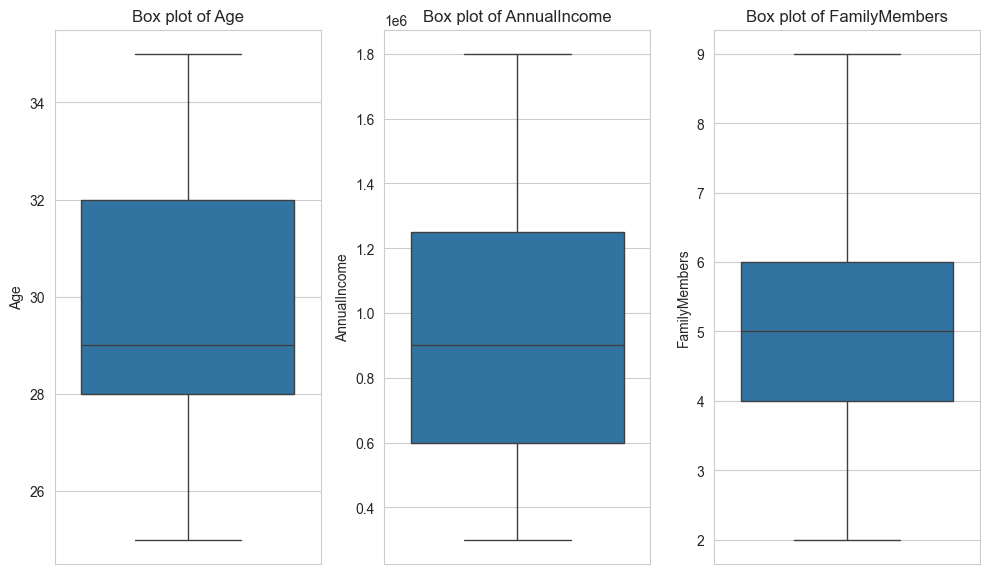

In [79]:
helper.plot_outliers(travel, ['Age', 'AnnualIncome', 'FamilyMembers'])

There are no outliers in the dataset.

We have checked for missing values, duplicates and outliers in the dataset and found none. The dataset is clean and ready for further analysis.

# Exploratory Data Analysis

## Summary statistics

In [80]:
travel[['Age', 'AnnualIncome', 'FamilyMembers']].describe()

,Age,AnnualIncome,FamilyMembers
count,1987.000000,1.987000e+03,1987.000000
mean,29.650226,9.327630e+05,4.752894
std,2.913308,3.768557e+05,1.609650
min,25.000000,3.000000e+05,2.000000
25%,28.000000,6.000000e+05,4.000000
50%,29.000000,9.000000e+05,5.000000
75%,32.000000,1.250000e+06,6.000000
max,35.000000,1.800000e+06,9.000000


## Data visualization

- Distribution and count of the features

In [81]:
columns_to_map = ['TravelInsurance', 'ChronicDiseases']

for col in columns_to_map:
    travel[col] = np.where(travel[col] == 1, 'Yes', 'No')

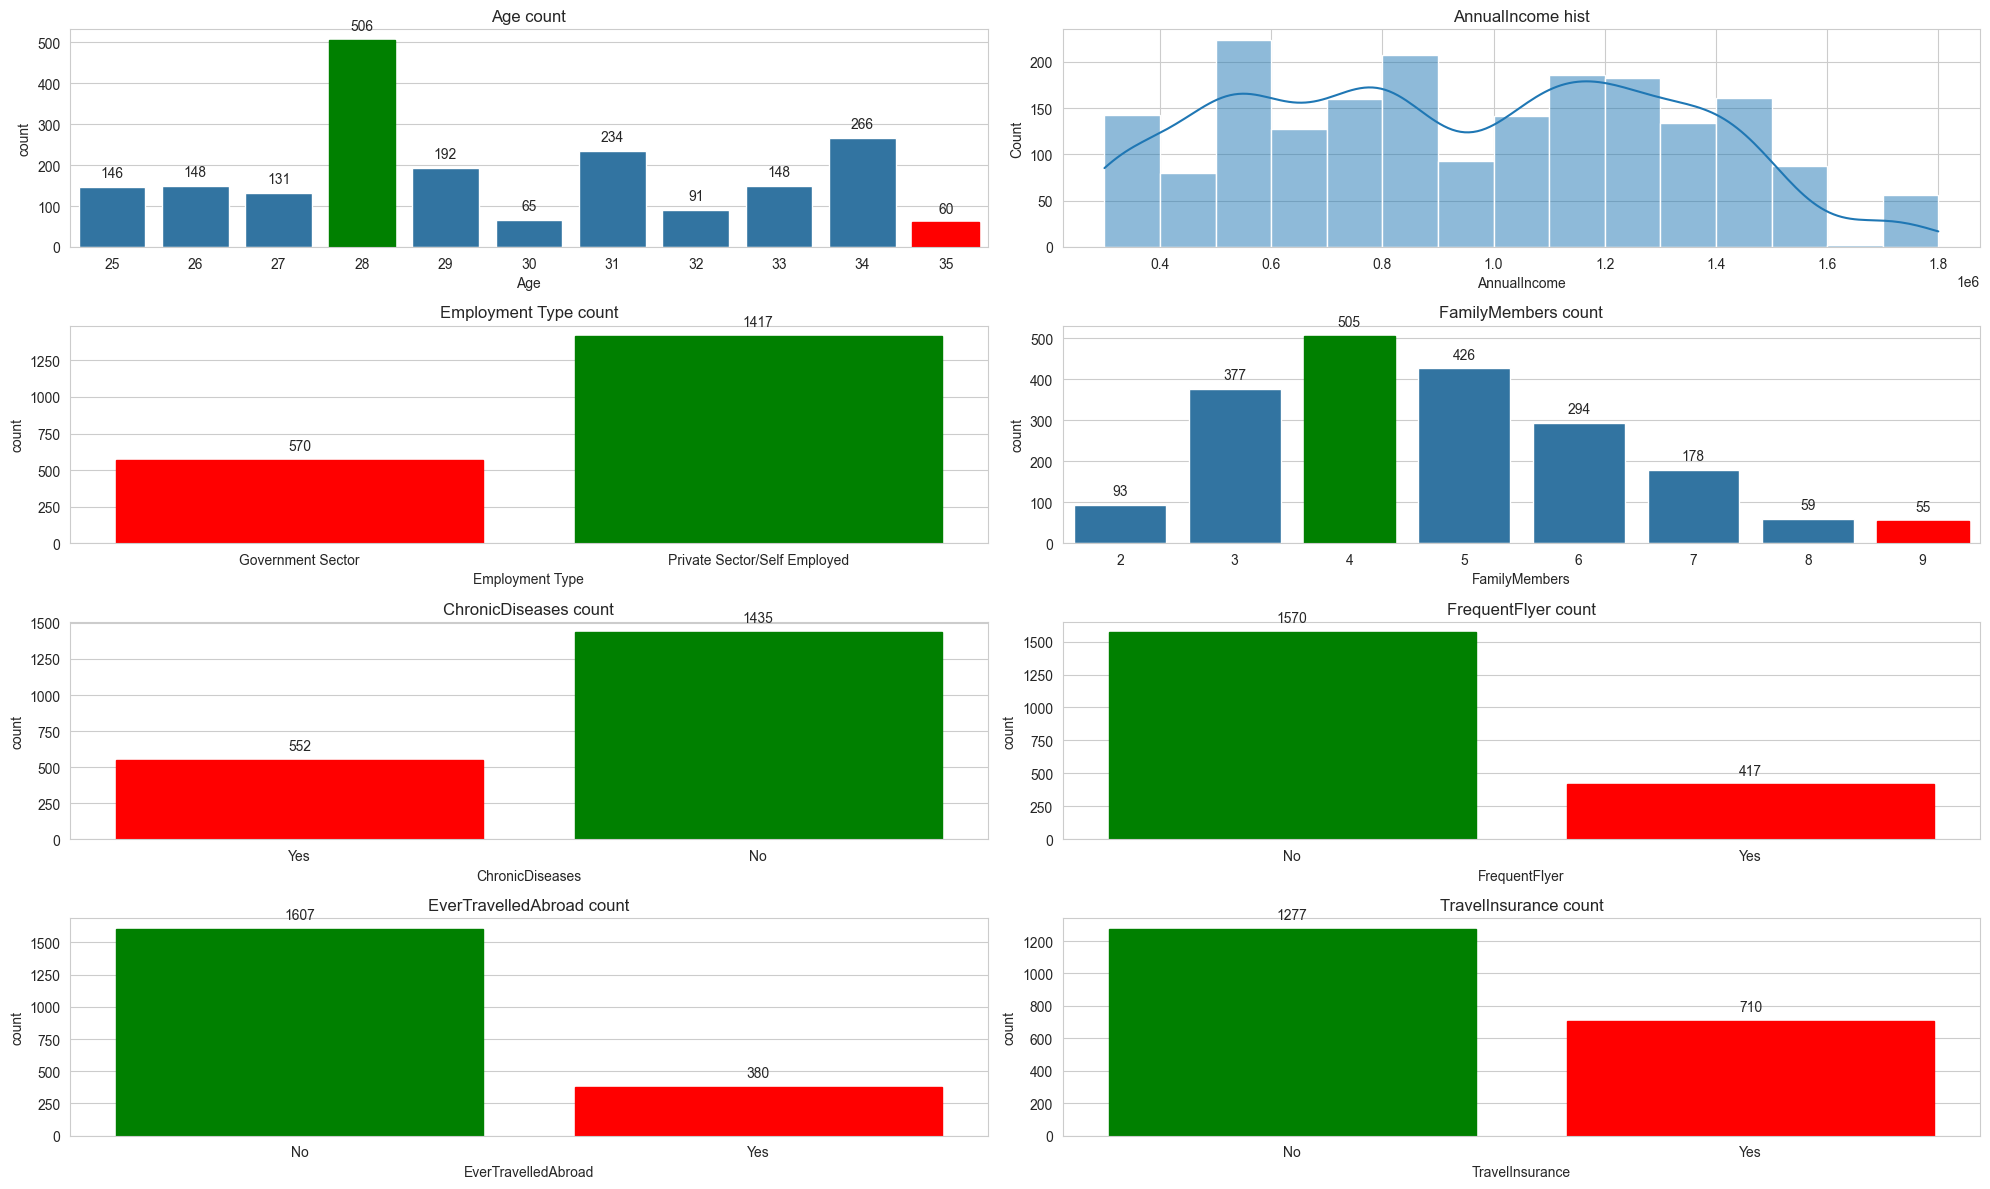

In [82]:
plot_specs = [('Age', 'count'), ('AnnualIncome', 'hist'), ('Employment Type', 'count'), ('FamilyMembers', 'count'),
              ('ChronicDiseases', 'count'), ('FrequentFlyer', 'count'), ('EverTravelledAbroad', 'count'),
              ('TravelInsurance', 'count')]
helper.plot_data(travel, plot_specs)

The charts reveal that most of the population falls within the age range of 25 to 35. A significant portion of this group is self-employed or works in the private sector. Notably, most individuals do not suffer from chronic diseases, are not frequent flyers, and have not traveled abroad. Furthermore, they typically do not possess travel insurance. The annual income among this group varies, with the majority earning between 300k to 1,6m rupees(2019 course, it's ~3,9k - 18k euros). In terms of family size, most of these individuals have between 3 to 5 family members.

## Correlation

Our dataset comprises both numerical and categorical data. We will use the Phi-K correlation coefficient to measure the correlation between the features and the target variable. The Phi-K correlation is a robust, entropy-based correlation ratio that works with categorical and numerical variables. It is an extension of the Pearson correlation coefficient, which only works with numerical variables.

The Phi-K correlation coefficient ranges from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 is a perfect negative correlation, and 0 suggests no correlation. In simpler terms, positive values mean that as one variable increases, the other variable tends to increase, while negative values mean that as one variable increases, the other variable tends to decrease.

We will also convert all yes/no values to 1/0 for better interpretability. Machine learning algorithms and statistical models work better with numerical data. By converting yes/no values to 1/0, we can include these variables in our correlation analysis and subsequent modeling.

In [83]:
mapping_dict = {feature: {'Yes': 1, 'No': 0} for feature in
                ['ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad', 'TravelInsurance', 'GraduateOrNot']}

mapping_dict['Employment Type'] = {'Government Sector': 0, 'Private Sector/Self Employed': 1}

travel = travel.replace(mapping_dict)

travel = travel.infer_objects()

C:\Users\duome\AppData\Local\Temp\ipykernel_10972\2182040790.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  travel = travel.replace(mapping_dict)


interval columns not set, guessing: ['Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad', 'TravelInsurance']


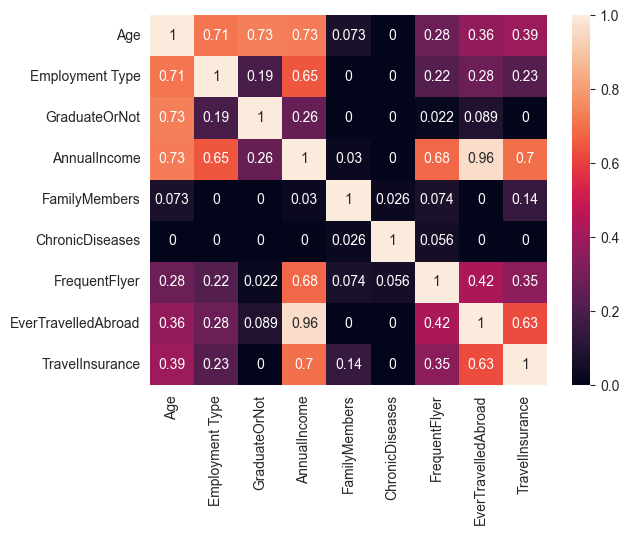

In [84]:
helper.plot_phik(travel, 'ID')

We can observe that the 'TravelInsurance' variable has a strong positive correlation with 'EverTravelledAbroad' and 'AnnualIncome.' It also shows a moderate correlation with 'FrequentFlyer' and 'Age'. These insights will be valuable for future feature selection and model development.

### Summary of EDA

The dataset we're examining is well-organized and clean, containing 1987 entries and 9 variables. It's a mix of numerical and categorical data, with 'TravelInsurance' as the target variable and the other 8 as predictors. A notable imbalance exists in the target variable, with 'No' entries (1277) outnumbering 'Yes' entries (710).

We've uncovered significant relationships within the data through the Phi-K correlation coefficient, a powerful correlation metric. Specifically, 'TravelInsurance' has a strong positive correlation with 'EverTravelledAbroad' and 'AnnualIncome' and a moderate correlation with 'FrequentFlyer' and 'Age.'

A visual inspection of the data shows that most of the population is between 25 and 35 years old, primarily self-employed or working in the private sector. These individuals generally do not have chronic diseases, are not frequent flyers, have not traveled abroad, and do not have travel insurance. Their annual income is typically between 300k to 1,6m rupees(~3k-16k euros), and they usually have a family size of 3 to 5 members.

The dataset is ready for the subsequent feature selection and model construction stages. However, the imbalance in the target variable is a factor to consider, as it may necessitate specific strategies during the model training phase. Due to the dataset's size, using cross-validation techniques could be beneficial for effectively evaluating model performance.

# Hypothesis Testing

## Annual Income and Travel Insurance Hypothesis 

- Hypothesis:
    - Null Hypothesis (H0): There is no significant difference in the mean annual income between individuals with and without travel insurance.
    - Alternative Hypothesis (H1): There is a significant difference in the mean annual income between individuals with and without travel insurance.

We will carry out a hypothesis test to establish whether a significant difference exists in the average annual income of travel insurance individuals versus those who do not. For this, we will employ the Mann-Whitney U test, a non-parametric statistical test used to compare two independent samples to see if they come from the same distribution.

The Mann-Whitney U test, a non-parametric statistical test, is a reliable tool when the data does not meet the assumptions of other tests, such as the t-test, which requires normally distributed data. It is based on the ranks of the data rather than their raw values, making it more robust to outliers and non-normality.

The U statistic, a key output of the Mann-Whitney U test, is a measure of the degree to which values in one sample exceed values in the other sample. A smaller U statistic indicates a greater degree of overlap between the two distributions, suggesting that they are not significantly different. Conversely, a larger U statistic indicates less overlap and a greater likelihood that the two samples come from different distributions.

Along with the U statistic, the test also provides a p-value. The p-value measures the probability that the observed data (or data more extreme) would occur if the null hypothesis were true. Suppose the p-value is less than a significance level (0.05). In that case, we reject the null hypothesis in favor of the alternative hypothesis, which is that there is a significant difference in the mean annual income between individuals with and without travel insurance.

In [85]:
travel_insurance = travel[travel['TravelInsurance'] == 1]['AnnualIncome']
no_travel_insurance = travel[travel['TravelInsurance'] == 0]['AnnualIncome']

from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(travel_insurance, no_travel_insurance)

print(f'U-statistic: {u_stat}')
print(f'P-value: {p_val}')

U-statistic: 670230.5
P-value: 3.0201010454885667e-70


The p-value is less than 0.05, indicating that we can reject the null hypothesis. Therefore, there is a significant difference in the mean annual income between individuals with and without travel insurance.

## Chronic Diseases and Travel Insurance Hypothesis

- Hypothesis:
    - Null Hypothesis (H0): There is no significant difference in the proportion of individuals with chronic diseases between those with and without travel insurance.
    - Alternative Hypothesis (H1): There is a significant difference in the proportion of individuals with chronic diseases between those with and without travel insurance.

The Chi-Square test, a statistical method we will employ, is particularly suited for this hypothesis testing due to its relevance to our variables of interest, 'ChronicDiseases' and 'TravelInsurance '. This test is designed to determine if a significant association exists between two categorical variables in a sample, which aligns perfectly with our research focus. Furthermore, the Chi-Square test assumes that the observations are independent of each other, a condition that is typically met in a dataset where each row represents a different individual. 

The Chi-Square test, known for its accuracy with large sample sizes, is an ideal choice for our dataset, which contains approximately 2000 entries. This test is non-parametric, meaning it does not assume a specific distribution for the variables. This flexibility makes it a versatile tool for hypothesis testing, adapting well to various research scenarios. 

The Chi-Square test is a test of association that can determine if there is a significant association between two categorical variables. In this case, we are interested in understanding if there is an association between 'ChronicDiseases' and 'TravelInsurance'. 

The results of the Chi-Square test will provide us with the following values:

- **Degrees of Freedom**: This value reflects the number of values in the final calculation of a statistic that are free to vary. In the context of a Chi-Square test, it is calculated as (number of rows - 1) * (number of columns - 1) in a contingency table.

- **Critical Value**: This point on the test distribution is compared to the test statistic to determine whether to reject the null hypothesis. The null hypothesis would be rejected if the Chi-Square statistic is greater than the critical value.

- **Chi-Square Statistic**: This is a single number that tells us how much difference exists between our observed counts and the counts we would expect if there were no relationship at all in the population. A more significant Chi-Square statistic corresponds to a tremendous difference between observed and expected counts.

- **P-value**: This is the probability of obtaining the observed data (or more extreme data) if the null hypothesis is true. It's a powerful tool in our statistical arsenal, as a smaller p-value indicates stronger evidence against the null hypothesis. If the p-value is less than 0.05, we reject the null hypothesis.

These results will help us understand the relationship between the variables we are testing and determine whether the observed differences are statistically significant.

In [86]:
contingency_table = pd.crosstab(travel['ChronicDiseases'], travel['TravelInsurance'])

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05

critical_value = chi2.ppf(1 - alpha, dof)

print(f"Degrees of Freedom: {dof}")
print(f"Critical Value: {round(critical_value, 3)}")
print(f"Chi-Square Statistic: {round(chi2_stat, 3)}")
print(f"P-value: {round(p_value, 5)}")

Degrees of Freedom: 1
Critical Value: 3.841
Chi-Square Statistic: 0.575
P-value: 0.44812


Chi-Square Statistic is less than the Critical Value, and the p-value is greater than 0.05. Therefore, we fail to reject the null hypothesis. There is no significant difference in the proportion of individuals with chronic diseases between those with and without travel insurance.

# Machine Learning models

## Model Selection

We will now proceed with the development of the machine learning model. We will use the following models for classification:
- Logistic Regression
- Random Forest
- Support Vector Machine
- K-Nearest Neighbors

We will evaluate the models using the following metrics:
- Accuracy
- Precision
- Recall
- F1-score

The best-performing model will be chosen based on its highest F1 score and recall. Subsequently, we will attempt to enhance this model by adjusting its hyperparameters and applying feature engineering techniques.

First, we will split the dataset into training, validation, and test sets. We will use the training set to train the models, the validation set to evaluate their performance, and the test set to assess the final model's generalization capabilities. The split will be 80/10/10, and the data will be stratified due to the imbalanced target variable, ensuring that each set maintains the same class proportions as the original dataset.

In [87]:
X_train, X_val, X_test, y_train, y_val, y_test = helper.prepare_data(travel, ['ID', 'TravelInsurance'],
                                                                     'TravelInsurance', 0.2, 0.5, 42, stratify=True)

- Creating a dictionary of models to evaluate.

In [88]:
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": make_pipeline(StandardScaler(), SVC(probability=True)),
    "K-Nearest Neighbors": make_pipeline(StandardScaler(), KNeighborsClassifier())
}

- Training the models and evaluating their performance.

In [89]:
final_report_df = helper.generate_classification_reports(models, X_train, y_train, X_val, y_val)

In [90]:
final_report_df

,Class,precision,recall,f1-score,support,Model
0,0,0.748387,0.906250,0.819788,128.000000,Logistic Regression
1,1,0.727273,0.450704,0.556522,71.000000,Logistic Regression
2,accuracy,0.743719,0.743719,0.743719,0.743719,Logistic Regression
3,macro avg,0.737830,0.678477,0.688155,199.000000,Logistic Regression
4,weighted avg,0.740854,0.743719,0.725859,199.000000,Logistic Regression
5,0,0.791667,0.890625,0.838235,128.000000,Random Forest
6,1,0.745455,0.577465,0.650794,71.000000,Random Forest
7,accuracy,0.778894,0.778894,0.778894,0.778894,Random Forest
8,macro avg,0.768561,0.734045,0.744514,199.000000,Random Forest
9,weighted avg,0.775179,0.778894,0.771359,199.000000,Random Forest


In [91]:
class_1_report_df = final_report_df[final_report_df['Class'] == '1']

In [92]:
class_1_report_df

,Class,precision,recall,f1-score,support,Model
1,1,0.727273,0.450704,0.556522,71.0,Logistic Regression
6,1,0.745455,0.577465,0.650794,71.0,Random Forest
11,1,0.790698,0.478873,0.596491,71.0,Support Vector Machine
16,1,0.701754,0.563380,0.625000,71.0,K-Nearest Neighbors


The model evaluation reveals that the Random Forest model outperforms the others with an f1-score of 0.65 and a recall of 0.577. Given these results, the next steps will be to optimize the Random Forest model through feature selection and hyperparameter tuning.

## Random Forest Model Optimization

## Features Selection

In this stage of feature selection, we will employ the Random Forest model because it can rank features based on their importance, which measures their contribution to the model's performance.

Our first step will be to compute the features' cumulative importance. This calculation will provide insights into how much each feature contributes to the model's predictive power.

Following that, we will identify the minimum number of features that collectively account for 95% of the importance. This step will help us pinpoint the most influential features that the model uses for making predictions.

Once we have identified these crucial features, we will select them in the model. This will reduce overfitting, enhance accuracy, and decrease training time.

Lastly, we will assess the model's performance after the feature selection process. This will involve training the model using the selected features and testing it to evaluate its performance. This assessment will provide a clear understanding of the model's performance when trained using only the most important features.

In [93]:
models["Random Forest"].fit(X_train, y_train)

importances = models["Random Forest"].feature_importances_

sorted_indices = np.argsort(importances)[::-1]

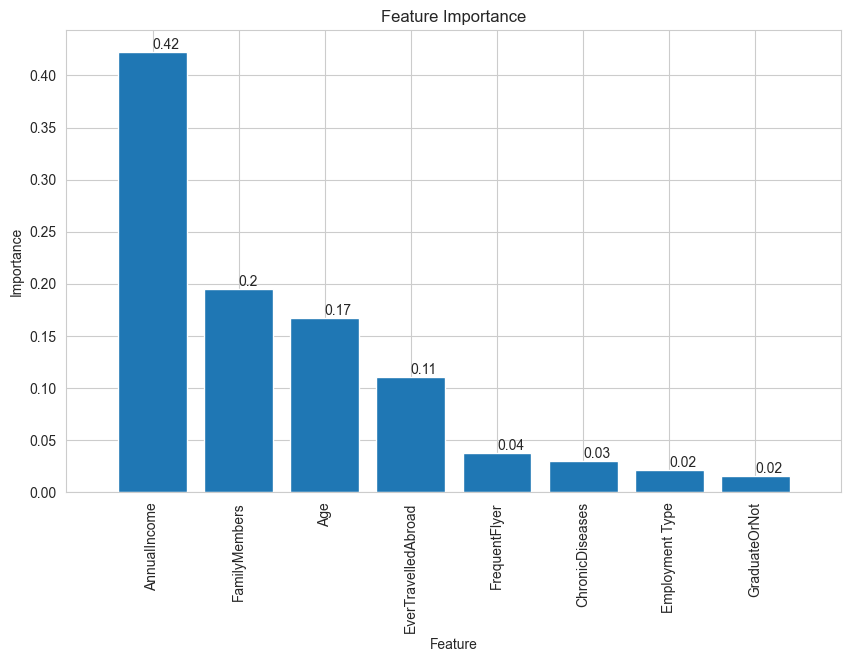

In [94]:
plt.figure(figsize=(10, 6))
bars = plt.bar(range(X_train.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom')

plt.show()

The chart above displays the importance of each feature in the Random Forest model. The most important features are 'AnnualIncome','FamilyMembers', and 'Age'.

- Cumulative feature importance

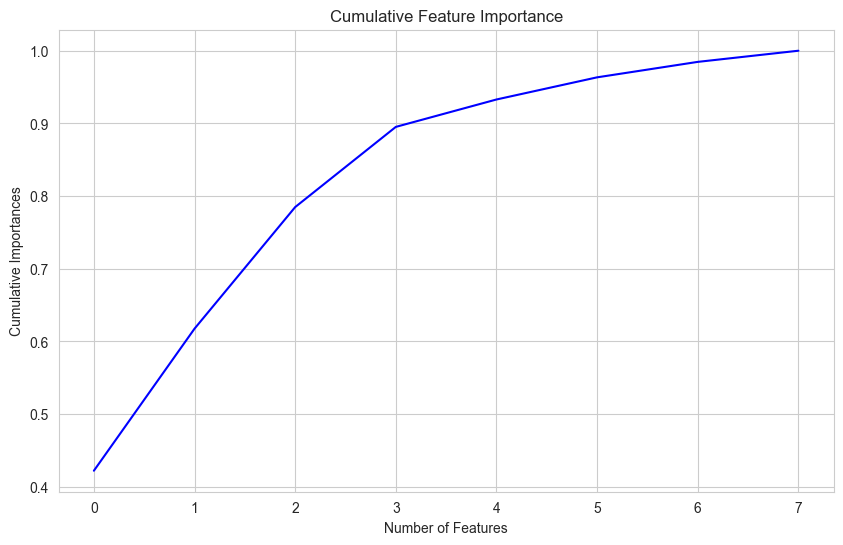

In [95]:
cumulative_importances = np.cumsum(importances[sorted_indices])

plt.figure(figsize=(10, 6))
plt.plot(range(len(importances)), cumulative_importances, 'b-')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importances')
plt.title('Cumulative Feature Importance')
plt.show()

In [96]:
n_features_for_95 = np.where(cumulative_importances > 0.95)[0][0] + 1
print('Number of features for 95% importance:', n_features_for_95)

Number of features for 95% importance: 6


In [97]:
important_feature_names = [X_train.columns[sorted_indices[i]] for i in range(n_features_for_95)]
important_feature_names

['AnnualIncome',
 'FamilyMembers',
 'Age',
 'EverTravelledAbroad',
 'FrequentFlyer',
 'ChronicDiseases']

- Model evaluation with important features

In [98]:
X_train_important = X_train[important_feature_names]
X_val_important = X_val[important_feature_names]
X_test_important = X_test[important_feature_names]

In [99]:
report_df = helper.generate_classification_reports({'Random Forest': models["Random Forest"]}, X_train_important,
                                                   y_train, X_val_important, y_val)
report_df

,Class,precision,recall,f1-score,support,Model
0,0,0.791667,0.890625,0.838235,128.000000,Random Forest
1,1,0.745455,0.577465,0.650794,71.000000,Random Forest
2,accuracy,0.778894,0.778894,0.778894,0.778894,Random Forest
3,macro avg,0.768561,0.734045,0.744514,199.000000,Random Forest
4,weighted avg,0.775179,0.778894,0.771359,199.000000,Random Forest


The model's performance remained consistent even after the feature selection process. Therefore, we will proceed with hyperparameter tuning using the Random Forest model, which now operates with fewer features.

## Hyperparameter tuning

We will employ GridSearchCV to identify the optimal hyperparameters for the Random Forest model. The hyperparameters we have chosen to tune are as follows:

- 'n_estimators': This parameter determines the number of trees in the forest. Increasing the number of trees can improve the model's performance but also increases computational complexity. We have chosen to test three different values: 100, 200, and 300.

- 'max_depth': This parameter controls the maximum depth of each tree. A higher depth can lead to a more complex model, which might result in overfitting. We will test three different depths: 15, 20, and 25.

- 'min_samples_split': This parameter defines the minimum number of samples required to split an internal node. Adjusting this parameter can help control overfitting. We will test three different values: 2, 5, and 10.

- 'min_samples_leaf': This parameter sets the minimum number of samples required to be at a leaf node. Like 'min_samples_split', this parameter can also help prevent overfitting. We will test three different values: 1, 2, and 4.

- 'class_weight': This parameter allows us to adjust the weights associated with classes. This can be useful when dealing with imbalanced datasets. We will test three different options: 'balanced', 'balanced_subsample', and None.

By tuning these hyperparameters, we aim to find the best combination that will yield the highest performance for our Random Forest model.

In [100]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

grid_search = GridSearchCV(estimator=models["Random Forest"], param_grid=param_grid, cv=5, n_jobs=-1, verbose=2,
                           scoring='recall', refit=True)

grid_search.fit(X_train_important, y_train)

best_params = grid_search.best_params_

best_params

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


{'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

We will save the best hyperparameters to a file for future use.

In [101]:
joblib.dump(best_params, 'best_params.pkl')

['best_params.pkl']

We have determined the optimal hyperparameters for the Random Forest model. The next step is to assess the model's performance using the validation set.

In [102]:
loaded_best_params = joblib.load('best_params.pkl')

best_rf = RandomForestClassifier(random_state=42, **loaded_best_params)

report_df = helper.generate_classification_reports({'Best Random Forest': best_rf}, X_train_important, y_train,
                                                   X_val_important, y_val)

report_df

,Class,precision,recall,f1-score,support,Model
0,0,0.781022,0.835938,0.807547,128.000000,Best Random Forest
1,1,0.661290,0.577465,0.616541,71.000000,Best Random Forest
2,accuracy,0.743719,0.743719,0.743719,0.743719,Best Random Forest
3,macro avg,0.721156,0.706701,0.712044,199.000000,Best Random Forest
4,weighted avg,0.738304,0.743719,0.739399,199.000000,Best Random Forest


After the hyperparameter tuning process, the Random Forest model's precision decreased while the recall stayed the same. As a result, we will continue with the tuned model for the test set evaluation, as it should handle class imbalance more effectively.

### Saving the model

In [103]:
joblib.dump(best_rf, 'best_rf.joblib')

['best_rf.joblib']

### Confusion matrix

A confusion matrix is a tool that helps visualize the performance of a classification model. It's a two-dimensional matrix where each row represents the instances of an actual class and each column represents the instances of a predicted class.

The four outcomes in a confusion matrix are:  
- True Positives (TP): The cases in which the model predicted yes (they have the condition), and they do have the condition.
- True Negatives (TN): The cases in which the model predicted no (they do not have the condition), and they do not have the condition.
- False Positives (FP): The cases in which the model predicted yes, but they do not actually have the condition. Also known as "Type I error".
- False Negatives (FN): The cases in which the model predicted no, but they actually do have the condition. Also known as "Type II error".

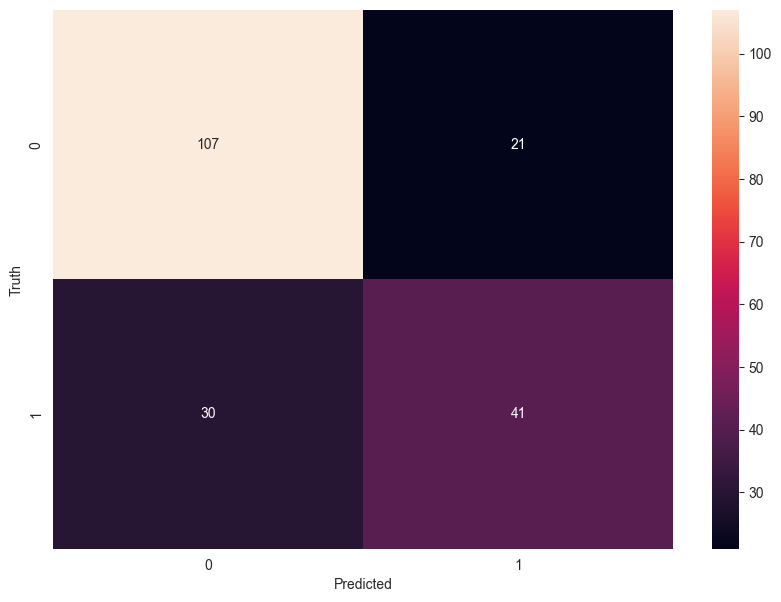

In [104]:
y_pred = best_rf.predict(X_val_important)
helper.plot_confusion_matrix(y_val, y_pred)

The confusion matrix indicates that the number of false positives is the lowest. This is crucial for our scenario because we aim to minimize instances where the model incorrectly predicts that a person will purchase insurance when they actually will not.

### ROC curve and AUC score

The Receiver Operating Characteristic (ROC) curve is a graphical tool used to assess the performance of a classifier. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. Each point on the ROC curve represents a different threshold value.

The Area Under the Curve (AUC) is a metric that quantifies the classifier's overall performance. It ranges from 0 to 1, with 1 indicating perfect discrimination and 0.5 indicating no better discrimination than random guessing.

When we plot the ROC curve and calculate the AUC score for a model, we aim to visualize its ability to distinguish between classes and identify the optimal classification threshold. The closer the curve is to the top left corner, the higher the AUC score, the better the model's performance. The ROC curve and AUC score provide a comprehensive view of the model's performance across all thresholds.

Best threshold: 0.6763073645484227


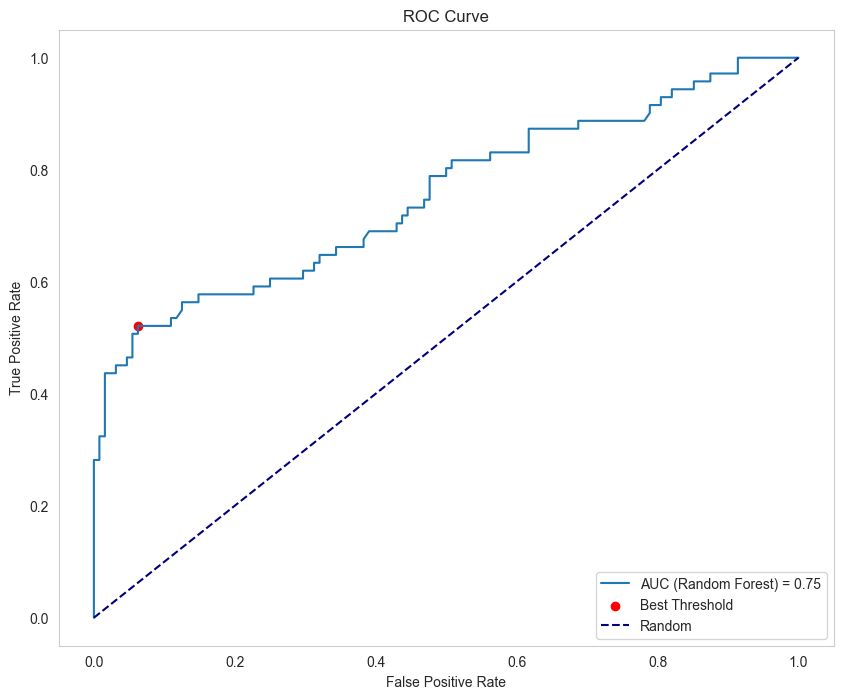

In [105]:
helper.plot_roc_curve(best_rf, X_val_important, y_val, 'Random Forest')

### Summary of the Random Forest model

The Random Forest model was optimized using feature selection and hyperparameter tuning. The most significant features for this model were 'AnnualIncome', 'FamilyMembers', and 'Age'. The model was tuned with the following optimal hyperparameters: 'n_estimators' set to 200, 'max_depth' to 20, 'min_samples_split' to 5, 'min_samples_leaf' to 1, and 'class_weight' set to 'balanced.' 

During the validation set evaluation, the model demonstrated a precision of 0.66 and a recall of 0.58 in predicting customers who are likely to purchase travel insurance. These scores, along with the F1 score of 0.61, which is the harmonic mean of precision and recall, indicate the model's effectiveness. The confusion matrix further confirmed the model's reliability, showing the lowest number of false positives. 

The model's AUC score, a performance measurement for classification problems at various threshold settings, was 0.75. This score suggests that the model has a good measure of separability and can distinguish between customers who will buy travel insurance and those who won't. 

The best threshold for the model, which is used for deciding on the classification step, was found to be 0.67. The ROC curve, a plot that illustrates the diagnostic ability of a binary classifier, was towards the left side of the plot, indicating a good sign of the model's performance.

We will now evaluate the performance of our optimized Random Forest model on the test set. This step is crucial as it allows us to assess how well our model generalizes to unseen data. The model's performance on the test set gives us a realistic estimate of how it would perform in a real-world setting. We will use the same performance metrics as before: precision, recall, and F1 score.

## Test set evaluation

In [106]:
report_df = helper.generate_classification_reports({'Best Random Forest': best_rf}, X_train_important, y_train,
                                                   X_test_important, y_test, train_model=False)

In [107]:
report_df

,Class,precision,recall,f1-score,support,Model
0,0,0.815603,0.898438,0.855019,128.00000,Best Random Forest
1,1,0.775862,0.633803,0.697674,71.00000,Best Random Forest
2,accuracy,0.804020,0.804020,0.804020,0.80402,Best Random Forest
3,macro avg,0.795732,0.766120,0.776347,199.00000,Best Random Forest
4,weighted avg,0.801424,0.804020,0.798881,199.00000,Best Random Forest


## ROC curve AUC score and confusion matrix

Best threshold: 0.6336632911837047


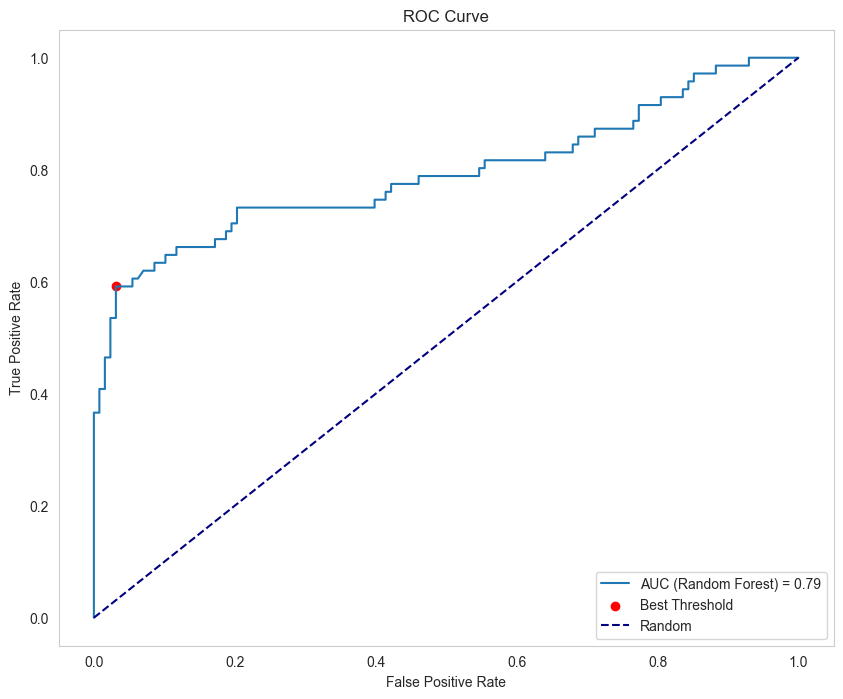

In [108]:
helper.plot_roc_curve(best_rf, X_test_important, y_test, 'Random Forest')

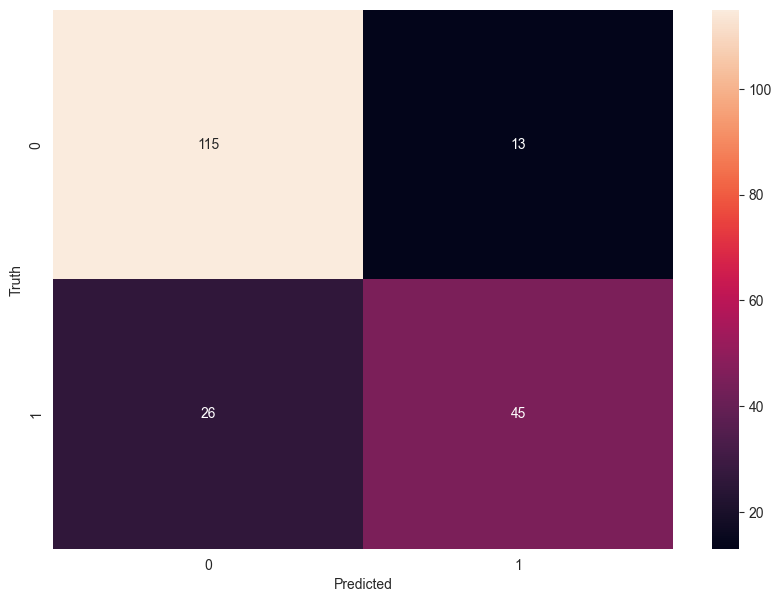

In [109]:
helper.plot_confusion_matrix(y_test, best_rf.predict(X_test_important))

# Conclusion

In this project, we focused on predicting customers likely to purchase travel insurance. The dataset was sourced from Kaggle and contained information about approximately 2000 customers to whom travel insurance was offered in 2019. 

We built various machine learning models, including Logistic Regression, Random Forest, Support Vector Machine, and K-Nearest Neighbors. After evaluating their performance, the Random Forest model emerged as the best performer and was selected for further optimization and final testing.

The Random Forest model was optimized through feature selection and hyperparameter tuning. The most significant features for this model were 'AnnualIncome', 'FamilyMembers', and 'Age'. The model was tuned with the following optimal hyperparameters: 'n_estimators' set to 100, 'max_depth' to 15, 'min_samples_split' to 2, 'min_samples_leaf' to 1, and 'class_weight' set to 'balanced.'

The model's performance on the test set was superior to the validation set when predicting customers purchasing travel insurance. The precision improved from 0.66 on the validation set to 0.77 on the test set. Similarly, recall increased from 0.58 to 0.633, and the F1 score rose from 0.61 to 0.69. This indicates that the model can accurately predict customers likely to purchase travel insurance. The confusion matrix reveals a minimal number of false positives, which is essential in this context. The ROC curve and an AUC score of 0.79 further validate the model's ability to differentiate between customers who will and will not purchase travel insurance.

In conclusion, the optimized Random Forest model strongly predicted customers likely to purchase travel insurance. For the best results, the model's predictions should be used with other sales strategies.

# Future improvements

While the optimized Random Forest model performed well in predicting customers likely to purchase travel insurance, there are several potential improvements that could be explored in future work:

1. **Adjust Classification Threshold**: The default threshold for binary classification tasks is 0.5, meaning that if the predicted probability of the positive class is more significant than 0.5, the instance is classified as positive. However, this threshold can be adjusted according to the specific needs and capabilities of the business. For example, if contacting potential customers is relatively inexpensive but missing a potential customer is costly, it might be beneficial to lower the threshold, resulting in more customers being classified as "likely to purchase insurance." This would increase the number of false positives (people predicted to purchase insurance who do not). Still, it would also decrease the number of false negatives (people who predicted not to buy insurance who actually would), which, in this case, might be a worthwhile trade-off. On the other hand, if contacting potential customers is expensive, it might be better to raise the threshold to ensure that the model is more confident in its predictions, reducing the number of false positives. It's important to note that adjusting the threshold should be done carefully, considering the business context and the costs associated with different types of classification errors.


2. **Experiment with Different Models**: While we used Logistic Regression, Random Forest, Support Vector Machine, and K-Nearest Neighbors in this project, there are many other machine learning models that could be tested. Models such as Gradient Boosting, XGBoost, and Neural Networks could potentially yield better results.


3. **Address Class Imbalance**: The dataset had an imbalance in the target variable. While we used the 'balanced' class weight in the Random Forest model to address this, other techniques such as oversampling the minority class, undersampling the majority class, or using a combination of both (SMOTE) could be explored.


4. **More Extensive Hyperparameter Tuning**: We could perform a more extensive search for optimal hyperparameters. Techniques such as Random Search or Bayesian Optimization could be used to find the best hyperparameters for the model.


5. **Use of External Data**: Incorporating external data related to the customers could potentially improve the model's performance. This could include data such as economic indicators, travel trends, or even social media data.

